وارد کردن کتابخانه‌ها

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import string

اتصال به Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


بارگذاری داده‌های آموزشی و تست

In [3]:
file_path = '/content/drive/My Drive/balanced_data1-1.csv'

train_dt = pd.read_csv(file_path)

print(train_dt.head())


<ipython-input-3-19cdb99abad7>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train_dt = pd.read_csv(file_path)


   overall vote  verified  reviewTime      reviewerID        asin  \
0        1  NaN      True  2016-06-19  A2PLH0M1QRU0YG  1059844575   
1        1  3.0      True  2017-01-26  A32H8T972W8Q39  106171327X   
2        1  3.0     False  2017-02-19  A1Z9EANX72A8EX  1444700650   
3        1  NaN      True  2016-05-03  A1E51BV5BPAADB  4126895493   
4        1  NaN      True  2016-11-01  A1BWUNE479C76A  6073894996   

                                               style     reviewerName  \
0                               {'Color:': ' Black'}  Amazon Customer   
1                                                NaN  Angelica Garcia   
2                     {'Format:': ' Kindle Edition'}          TKandKK   
3                            {'Color:': ' Fire red'}           Moejha   
4  {'Size:': ' One USB Port', 'Color:': ' Black 2...               BK   

                                          reviewText  \
0  Keeps cutting out... phone screen image on TV ...   
1  Not the one we ordered exactly 

In [26]:
file_path = '/content/drive/My Drive/test_data.csv'

test_dt = pd.read_csv(file_path)

# print(test_dt.head())


دانلود پکیج‌های NLTK

In [29]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

تعریف تابع برای پاکسازی متن


In [30]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    if not isinstance(text, str):
        return ''

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = re.sub(r'\d+', '', text)

    text = text.translate(str.maketrans('', '', string.punctuation))

    text = text.lower()

    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    text = ' '.join(text.split())

    return text


In [31]:
test_dt['reviewText_cleaned'] = test_dt['reviewText'].apply(clean_text)
test_dt['summary_cleaned'] = test_dt['summary'].apply(clean_text)

تعریف ویژگی‌ها و برچسب‌ها

In [10]:
X = train_dt[['reviewText_cleaned', 'summary_cleaned']]
y = train_dt['overall']

تبدیل برچسب‌ها به قالب one-hot encoding



In [11]:
y = to_categorical(y - 1)

تقسیم داده‌های آموزشی و تست


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ایجاد Tokenizer برای متن و خلاصه


In [13]:
tokenizer_review = Tokenizer(num_words=6000)
tokenizer_summary = Tokenizer(num_words=1000)

 آموزش و تبدیل و پدینگ متون به توالی عددی در داده‌های آموزشی


In [14]:
tokenizer_review.fit_on_texts(X['reviewText_cleaned'])
tokenizer_summary.fit_on_texts(X['summary_cleaned'])

In [15]:
tokenizer_review.fit_on_texts(X['reviewText_cleaned'])
tokenizer_summary.fit_on_texts(X['summary_cleaned'])

In [16]:
X_train_review_seq = tokenizer_review.texts_to_sequences(X_train['reviewText_cleaned'])
X_train_summary_seq = tokenizer_summary.texts_to_sequences(X_train['summary_cleaned'])

In [17]:
X_test_review_seq = tokenizer_review.texts_to_sequences(X_test['reviewText_cleaned'])
X_test_summary_seq = tokenizer_summary.texts_to_sequences(X_test['summary_cleaned'])

In [18]:

X_train_review_pad = pad_sequences(X_train_review_seq, maxlen=1400)
X_train_summary_pad = pad_sequences(X_train_summary_seq, maxlen=500)

X_test_review_pad = pad_sequences(X_test_review_seq, maxlen=1400)
X_test_summary_pad = pad_sequences(X_test_summary_seq, maxlen=500)

تعریف کال بک برای توقف دستی آموزش و توقف پیش از اورفیت شدن


In [19]:
from tensorflow.keras.callbacks import Callback

class ManualStopCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if int(epoch) < 10:
          answer = 'n'
        else:
          answer = input(f"Epoch {epoch + 1} ended. Do you want to stop training? (y/n): ")
        if answer.lower() == 'y':
            print("Stopping training...")
            self.model.stop_training = True


In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


In [22]:
manual_check = ManualStopCallback()

ایجاد مدل LSTM با ورودی‌های خلاصه و متن

In [23]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Flatten

input_review = Input(shape=(1400,))
x_review = Embedding(input_dim=6000, output_dim=128)(input_review)
x_review = LSTM(64)(x_review)

input_summary = Input(shape=(500,))
x_summary = Embedding(input_dim=1000, output_dim=128)(input_summary)
x_summary = LSTM(32)(x_summary)

merged = Concatenate()([x_review, x_summary])
output = Dense(5, activation='softmax')(merged)

model = Model(inputs=[input_review, input_summary], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1400)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 500)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1400, 128)      │        768,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 500, 128)       │        128,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         49,408 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         20,608 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 96)             │              0 │ lstm[0][0],            │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 5)              │            485 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 966,501 (3.69 MB)

 Trainable params: 966,501 (3.69 MB)

 Non-trainable params: 0 (0.00 B)

آموزش مدل با استفاده از داده‌های آموزشی


In [24]:
history = model.fit(
    [X_train_review_pad, X_train_summary_pad],
    y_train,
    epochs=30,
    validation_data=([X_test_review_pad, X_test_summary_pad],y_test),
    callbacks=[manual_check, early_stopping],
    batch_size=128
)


Epoch 1/30
3118/3118 ━━━━━━━━━━━━━━━━━━━━ 278s 87ms/step - accuracy: 0.4868 - loss: 0.3941 - val_accuracy: 0.5724 - val_loss: 0.3443
Epoch 2/30
3118/3118 ━━━━━━━━━━━━━━━━━━━━ 319s 88ms/step - accuracy: 0.5921 - loss: 0.3337 - val_accuracy: 0.5855 - val_loss: 0.3363
Epoch 3/30
3118/3118 ━━━━━━━━━━━━━━━━━━━━ 326s 89ms/step - accuracy: 0.6161 - loss: 0.3176 - val_accuracy: 0.5876 - val_loss: 0.3334
Epoch 4/30
3118/3118 ━━━━━━━━━━━━━━━━━━━━ 327s 91ms/step - accuracy: 0.6382 - loss: 0.3039 - val_accuracy: 0.5882 - val_loss: 0.3344
Epoch 5/30
3118/3118 ━━━━━━━━━━━━━━━━━━━━ 317s 89ms/step - accuracy: 0.6594 - loss: 0.2910 - val_accuracy: 0.5897 - val_loss: 0.3368


ترسیم تاریخچه آموزش مدل


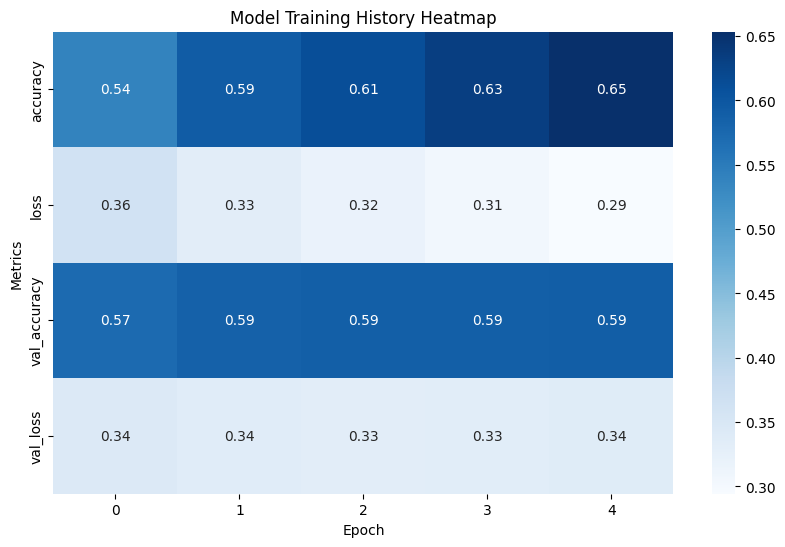

In [65]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(10, 6))
sns.heatmap(history_df.T, annot=True, cmap="Blues", cbar=True)
plt.title("Model Training History Heatmap")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.show()


محاسبه و ترسیم ماتریس سردرگمی


In [55]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = model.predict([X_test_review_pad, X_test_summary_pad])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)



3118/3118 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step


NameError: name 'class_labels' is not defined

<Figure size 800x600 with 0 Axes>

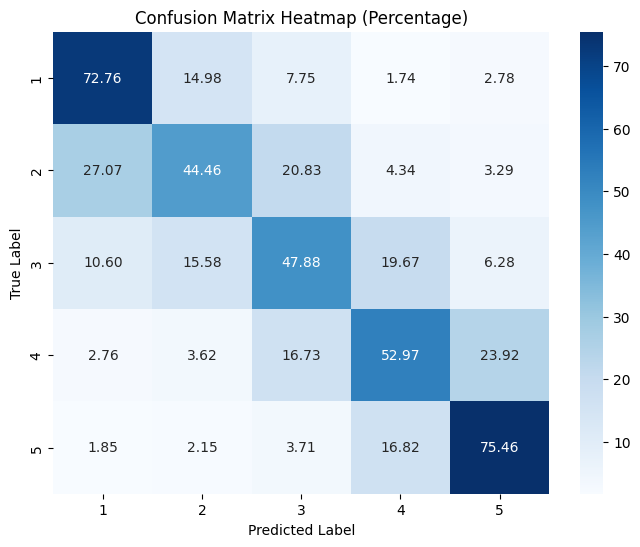

In [64]:
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=train_dt['overall'].unique(), yticklabels=train_dt['overall'].unique())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap (Percentage)")
plt.show()


 آموزش و تبدیل و پدینگ متون به توالی عددی در داده‌های تست


In [32]:
X_test_f_review_seq = tokenizer_review.texts_to_sequences(test_dt['reviewText_cleaned'])
X_test_f_summary_seq = tokenizer_summary.texts_to_sequences(test_dt['summary_cleaned'])

In [34]:
X_test_f_review_pad = pad_sequences(X_test_f_review_seq, maxlen=1400)
X_test_f_summary_pad = pad_sequences(X_test_f_summary_seq, maxlen=500)

پیشبینی در داده های تست

In [36]:
prediction = model.predict([X_test_f_review_pad, X_test_f_summary_pad])

predicted_class = np.argmax(prediction, axis=1)

print("Predicted class:", predicted_class)

625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step
Predicted class: [0 0 0 ... 4 4 3]


In [38]:
predicted_class_dt = pd.DataFrame(predicted_class, columns=['predicted'])

In [49]:
predicted_class_dt = predicted_class_dt['predicted'] + 1

ذخیره دیتا پیشبینی

In [51]:
predicted_class_dt.to_csv('/content/drive/My Drive/q2_submission.csv', index=False)
